<a href="https://colab.research.google.com/github/aiooq/Files/blob/master/ML_CreditScore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Глобальные либы
import numpy as np
import pandas as pd
import pickle
import random

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# либы из 2 урока
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

In [ ]:
# !pip install xgboost
# !pip install lightgbm
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# либы из 3(4) урока
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [ ]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [ ]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [ ]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [ ]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [ ]:
# input
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

LEARN_DATASET_PATH = 'training_project_data.csv'

# output
SCALER_FILE_PATH = 'scaler.pkl'
MODEL_FILE_PATH = 'model.pkl'

Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [ ]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [ ]:
df_train.shape

(7500, 17)

In [ ]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                             482087.0
Years in current job                           NaN
Tax Liens                                      0.0
Number of Open Accounts                       11.0
Years of Credit History                       26.3
Maximum Open Credit                       685960.0
Number of Credit Problems                      1.0
Months since last delinquent                   NaN
Bankruptcies                                   1.0
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                     99999999.0
Current Credit Balance                     47386.0
Monthly Debt                                7914.0
Credit Score                                 749.0
Credit Default                                   0
Name: 0, dtype: object

In [ ]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [ ]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [ ]:
df_test.shape

(2500, 16)

Обучающий дата сет

In [ ]:
#df = pd.read_csv(LEARN_DATASET_PATH)

START!

In [ ]:
df=df_train

In [ ]:
TARGET_NAME = 'Credit Default'
#TARGET_NAME = 'NEXT_MONTH_DEFAULT'

In [ ]:
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Подготовка данных

In [ ]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [ ]:
df_num_features = df.select_dtypes(include=['float64'])
df_num_features.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,482087.0,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,99999999.0,47386.0,7914.0,749.0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,264968.0,394972.0,18373.0,737.0
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,99999999.0,308389.0,13651.0,742.0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,121396.0,95855.0,11338.0,694.0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,125840.0,93309.0,7180.0,719.0


In [ ]:
columns_object = list(df.select_dtypes(include='object'))

In [ ]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

,Home Ownership,Years in current job,Purpose,Term
0,Own Home,NaN,debt consolidation,Short Term
1,Own Home,10+ years,debt consolidation,Long Term
2,Home Mortgage,8 years,debt consolidation,Short Term
3,Own Home,6 years,debt consolidation,Short Term
4,Rent,8 years,debt consolidation,Short Term


In [ ]:
df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [ ]:
df['Home Ownership'].unique()

array(['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage'], dtype=object)

Первичное представление данных

In [ ]:
df['Home Ownership'].nunique()

4

In [ ]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Обработка пропусков

In [ ]:
df.isna()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
7496,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7497,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
7498,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False


In [ ]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Маркеруем столбцы

In [ ]:
IGNORE_FEATURE_NAMES=['Annual Income','Years in current job','Months since last delinquent','Bankruptcies','Credit Score']
BASE_FEATURE_NAMES = df.columns.drop([TARGET_NAME]).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + IGNORE_FEATURE_NAMES).tolist()

Разбиение на трейн и тест

In [ ]:
x = df.drop(columns=NEW_FEATURE_NAMES)
y = df[TARGET_NAME]

Практика из 2 урока

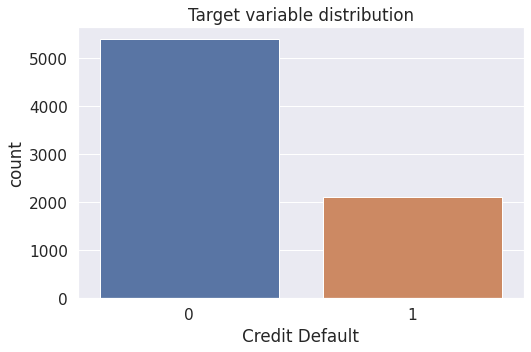

In [ ]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

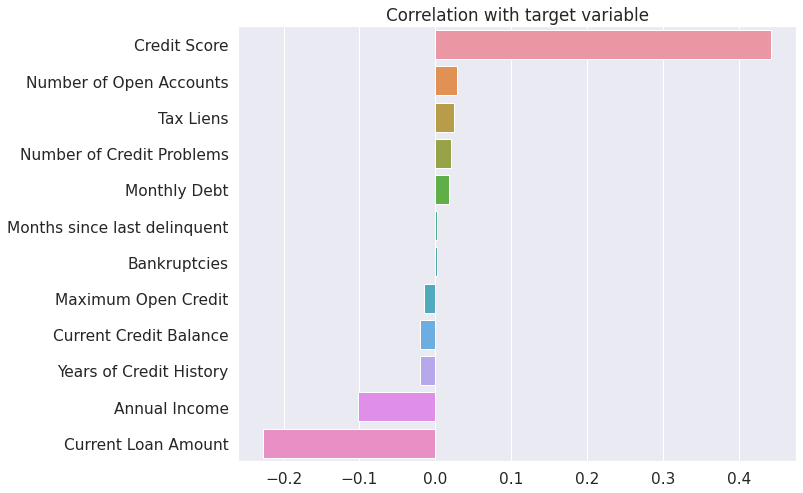

In [ ]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

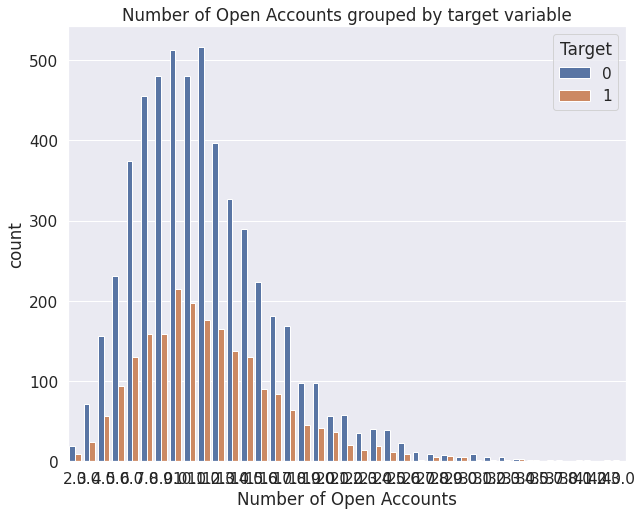

In [ ]:
plt.figure(figsize=(10, 8))

CURRENT='Number of Open Accounts'
#CURRENT='PAY_1'#'Credit Score'
#column='Current Loan Amount'

sns.countplot(x=CURRENT, hue=TARGET_NAME, data=df)
plt.title(CURRENT+' grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [ ]:
sample = df[[CURRENT, TARGET_NAME]].sample(1000)
sample.head()

,Number of Open Accounts,Credit Default
3408,15.0,0
4923,6.0,0
4853,13.0,1
2952,16.0,0
3484,2.0,1


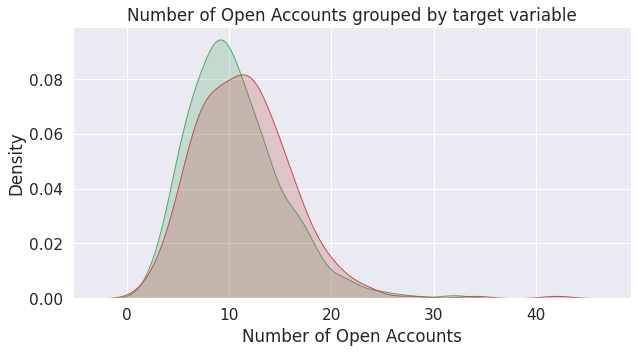

In [ ]:
series = sample[CURRENT]
series_0 = series[sample[TARGET_NAME] == 0]
series_1 = series[sample[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(series_0, shade=True, label='No default', color='g')
sns.kdeplot(series_1, shade=True, label='Default', color='r')

plt.xlabel(CURRENT)
plt.title(CURRENT+' grouped by target variable')
plt.show()

In [ ]:
shapiro(series)

(0.9390556812286377, 8.088561062925346e-20)

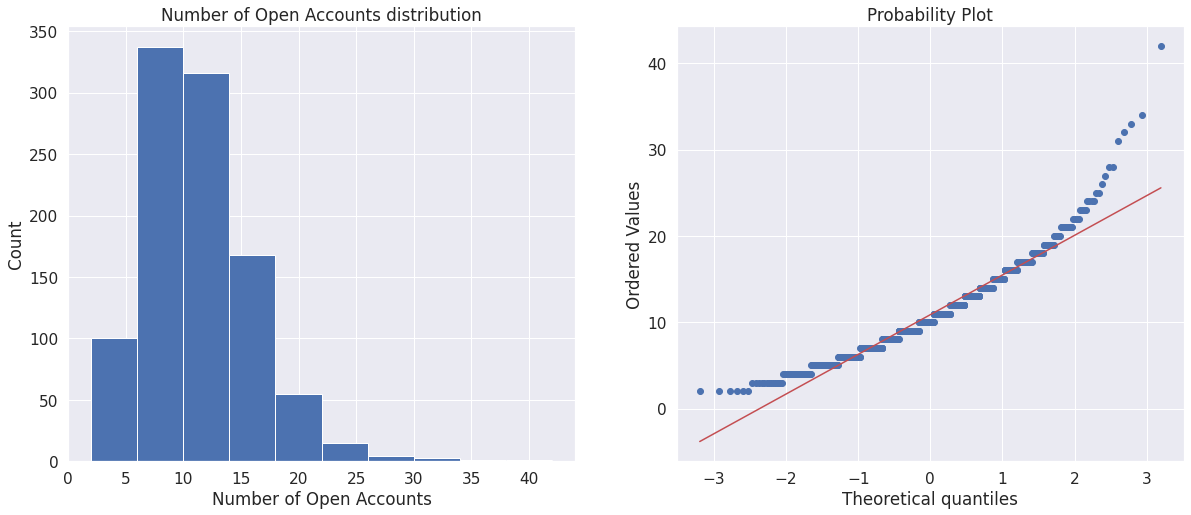

In [ ]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel(CURRENT)
ax1.set_ylabel('Count')
ax1.set_title(CURRENT+' distribution')
series.hist()

plt.subplot(122)
probplot(series, dist='norm', plot=plt)

plt.show()

In [ ]:
mannwhitneyu(series_0, series_1)

MannwhitneyuResult(statistic=90220.5, pvalue=0.0012164915417122583)

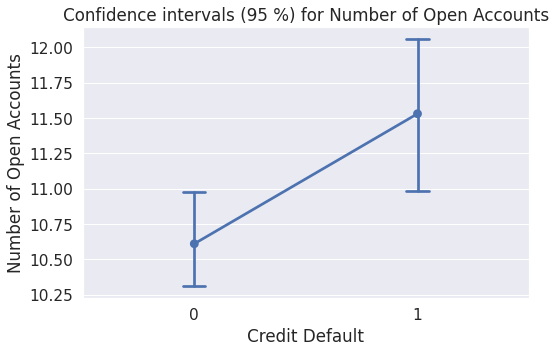

In [ ]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y=CURRENT, data=sample, capsize=.1)

plt.title('Confidence intervals (95 %) for '+CURRENT)
plt.show()

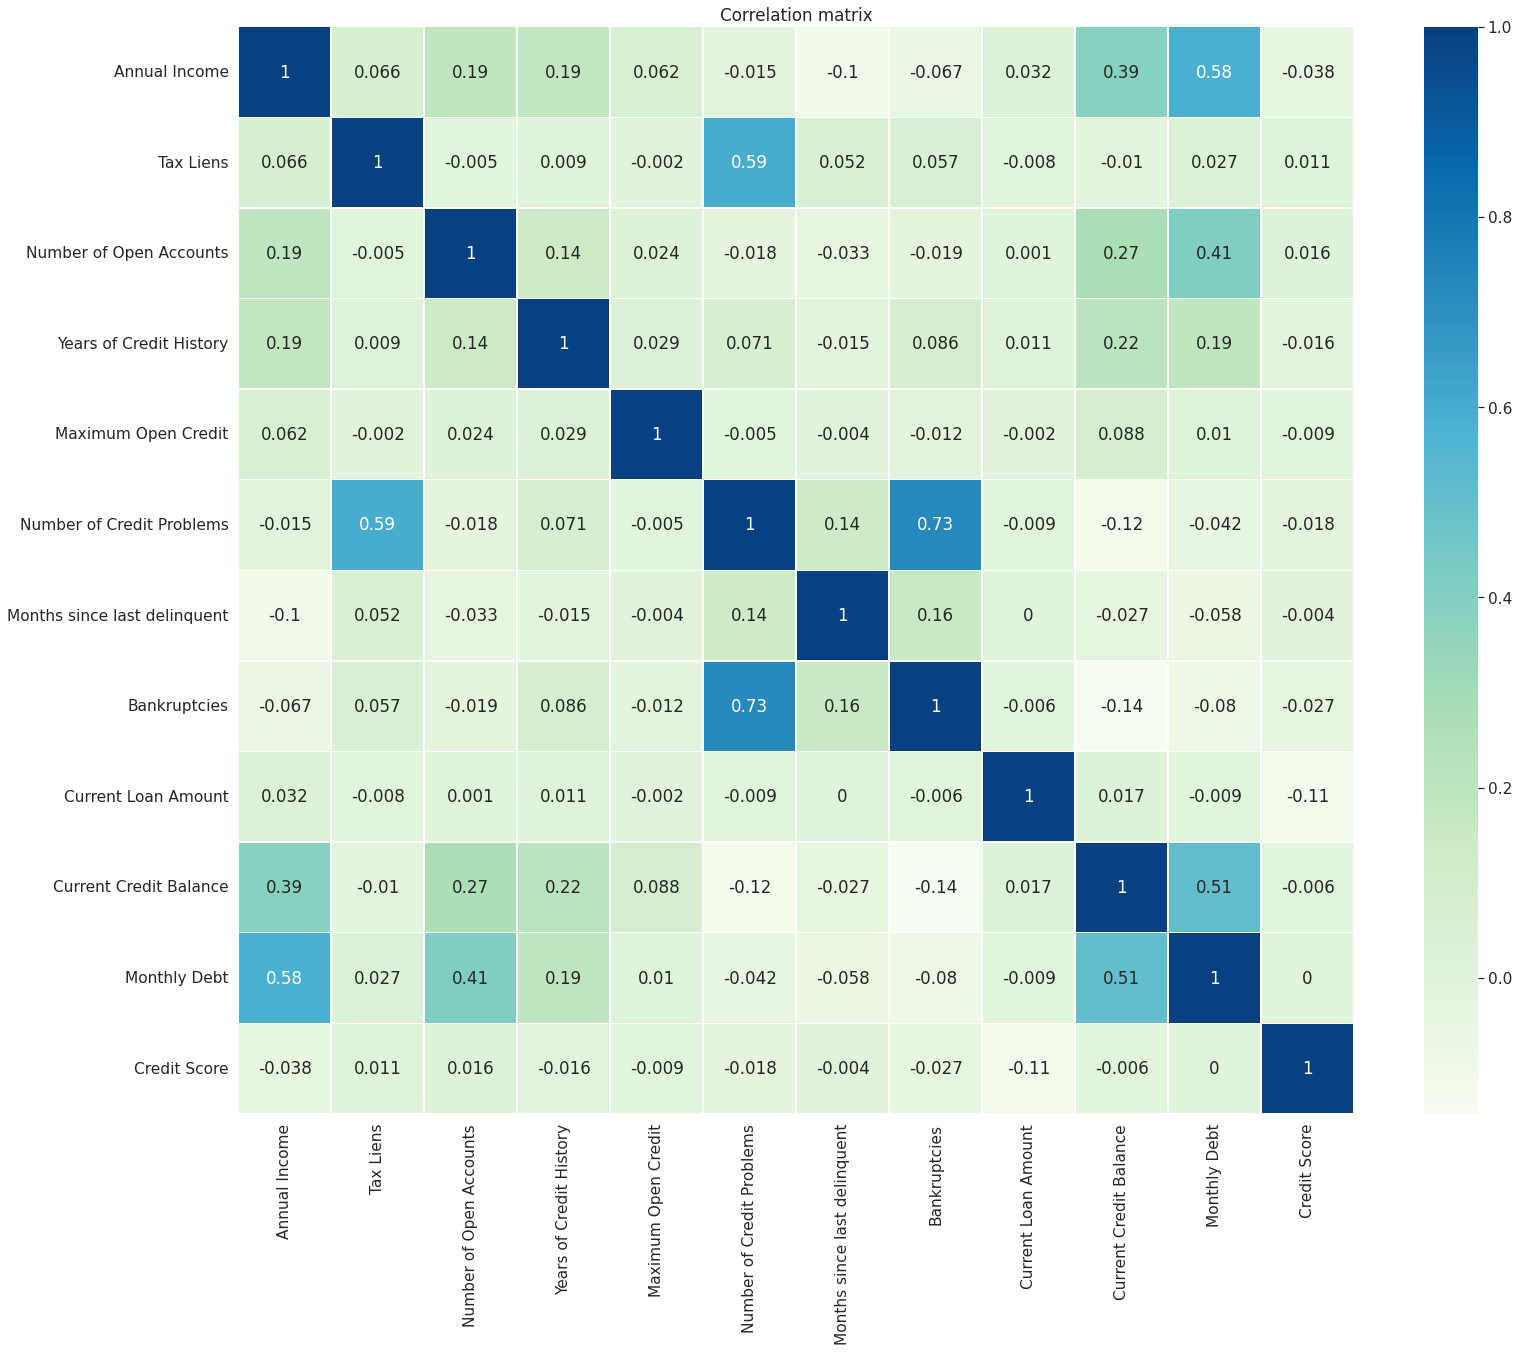

In [ ]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Практика из 3 урока

In [ ]:
NUMERIC_FEATURE_NAMES = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                         'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

NUMERIC_FEATURE_NAMES = df[NEW_FEATURE_NAMES].select_dtypes(include=['float64']).columns.tolist()

FEATURE_NAMES_SELECTED = NEW_FEATURE_NAMES#NUMERIC_FEATURE_NAMES + NEW_FEATURE_NAMES

Нормализация данных

In [ ]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

df = df_norm.copy()

# test
df_norm = df_test.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

df_test = df_norm.copy()

Разбиение на train и test

In [ ]:
X = df[NUMERIC_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

XX_test = df_test[NUMERIC_FEATURE_NAMES]

In [ ]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    4047
1    3156
Name: Credit Default, dtype: int64

In [ ]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

# Построение и оценка базовых моделей
## Логистическая регрессия

In [ ]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

# Отложенный тест
yy_test_pred = model_lr.predict(XX_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.59      0.82      0.69      4047
           1       0.55      0.28      0.37      3156

    accuracy                           0.59      7203
   macro avg       0.57      0.55      0.53      7203
weighted avg       0.58      0.59      0.55      7203

TEST

              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1340
           1       0.38      0.28      0.32       535

    accuracy                           0.67      1875
   macro avg       0.56      0.55      0.55      1875
weighted avg       0.64      0.67      0.65      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1099  241
1                385  150


k ближайших соседей

In [ ]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

# Отложенный тест
yy_test_pred = model_knn.predict(XX_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      4047
           1       0.73      0.70      0.71      3156

    accuracy                           0.75      7203
   macro avg       0.75      0.75      0.75      7203
weighted avg       0.75      0.75      0.75      7203

TEST

              precision    recall  f1-score   support

           0       0.72      0.67      0.69      1340
           1       0.30      0.35      0.32       535

    accuracy                           0.58      1875
   macro avg       0.51      0.51      0.51      1875
weighted avg       0.60      0.58      0.59      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               896  444
1               349  186


XGBoost

In [ ]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

# Отложенный тест
yy_test_pred = model_xgb.predict(XX_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.76      0.72      4047
           1       0.65      0.56      0.60      3156

    accuracy                           0.67      7203
   macro avg       0.67      0.66      0.66      7203
weighted avg       0.67      0.67      0.67      7203

TEST

              precision    recall  f1-score   support

           0       0.77      0.71      0.74      1340
           1       0.40      0.48      0.43       535

    accuracy                           0.64      1875
   macro avg       0.59      0.59      0.59      1875
weighted avg       0.67      0.64      0.65      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               953  387
1               280  255


LightGBM

In [ ]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

# Отложенный тест
yy_test_pred = model_lgbm.predict(XX_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4047
           1       0.87      0.88      0.87      3156

    accuracy                           0.89      7203
   macro avg       0.89      0.89      0.89      7203
weighted avg       0.89      0.89      0.89      7203

TEST

              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1340
           1       0.37      0.40      0.39       535

    accuracy                           0.64      1875
   macro avg       0.56      0.57      0.56      1875
weighted avg       0.64      0.64      0.64      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               980  360
1               321  214


CatBoost

In [ ]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

# Отложенный тест
yy_test_pred = model_lgbm.predict(XX_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      4047
           1       0.86      0.82      0.84      3156

    accuracy                           0.86      7203
   macro avg       0.86      0.86      0.86      7203
weighted avg       0.86      0.86      0.86      7203

TEST

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1340
           1       0.39      0.41      0.40       535

    accuracy                           0.65      1875
   macro avg       0.57      0.58      0.57      1875
weighted avg       0.65      0.65      0.65      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               990  350
1               314  221


Выбор лучшей модели и подбор гиперпараметров

In [ ]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

In [ ]:
params = {'n_estimators':[50, 100, 200, 500], 
          'max_depth':[3, 5, 7, 10],
          'learning_rate':[0.001, 0.01, 0.05, 0.1]}

In [ ]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [ ]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

CPU times: user 3.08 s, sys: 663 ms, total: 3.74 s
Wall time: 50.1 s


In [ ]:
rs.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}

In [ ]:
rs.best_score_

0.6561425830661186

In [ ]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=7, learning_rate=0.1,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4047
           1       0.87      0.84      0.85      3156

    accuracy                           0.87      7203
   macro avg       0.87      0.87      0.87      7203
weighted avg       0.87      0.87      0.87      7203

TEST

              precision    recall  f1-score   support

           0       0.75      0.74      0.75      1340
           1       0.38      0.39      0.38       535

    accuracy                           0.64      1875
   macro avg       0.57      0.57      0.57      1875
weighted avg       0.65      0.64      0.64      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               994  346
1               325  210
CPU times: user 1.82 s, sys: 184 ms, total: 2.01 s
Wall time: 1.16 s


In [ ]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

# Практика 4 урока

In [ ]:
final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=7, learning_rate=0.1,
                                      silent=True, random_state=21)
#final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
#                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      4047
           1       0.87      0.84      0.85      3156

    accuracy                           0.87      7203
   macro avg       0.87      0.87      0.87      7203
weighted avg       0.87      0.87      0.87      7203

TEST

              precision    recall  f1-score   support

           0       0.75      0.74      0.75      1340
           1       0.38      0.39      0.38       535

    accuracy                           0.64      1875
   macro avg       0.57      0.57      0.57      1875
weighted avg       0.65      0.64      0.64      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               994  346
1               325  210


In [ ]:
final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=7, learning_rate=0.1,l2_leaf_reg=10,
                                      silent=True, random_state=21)
#final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
#                                      l2_leaf_reg=10,
#                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4047
           1       0.84      0.81      0.82      3156

    accuracy                           0.85      7203
   macro avg       0.85      0.84      0.85      7203
weighted avg       0.85      0.85      0.85      7203

TEST

              precision    recall  f1-score   support

           0       0.75      0.72      0.74      1340
           1       0.37      0.40      0.38       535

    accuracy                           0.63      1875
   macro avg       0.56      0.56      0.56      1875
weighted avg       0.64      0.63      0.64      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               969  371
1               320  215


In [ ]:
final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=7,learning_rate=0.1,l2_leaf_reg=10,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21)

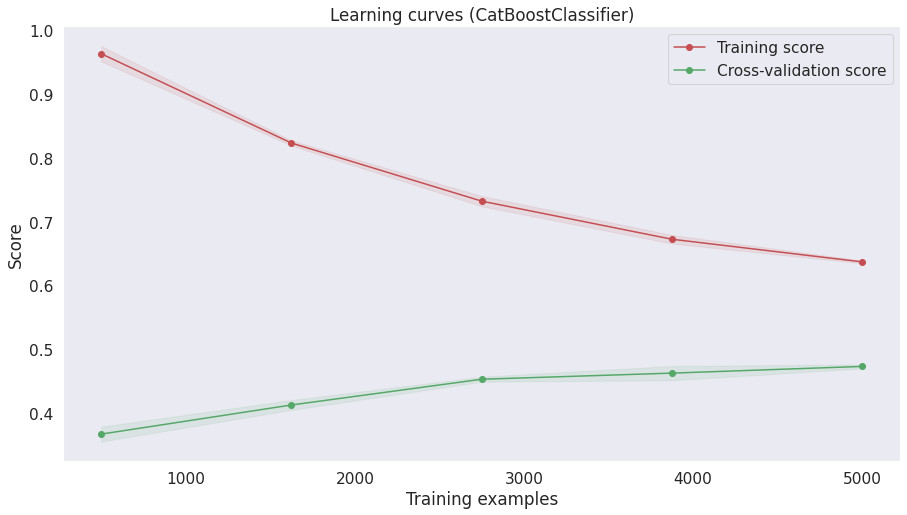

In [ ]:
show_learning_curve_plot(final_model, X, y)

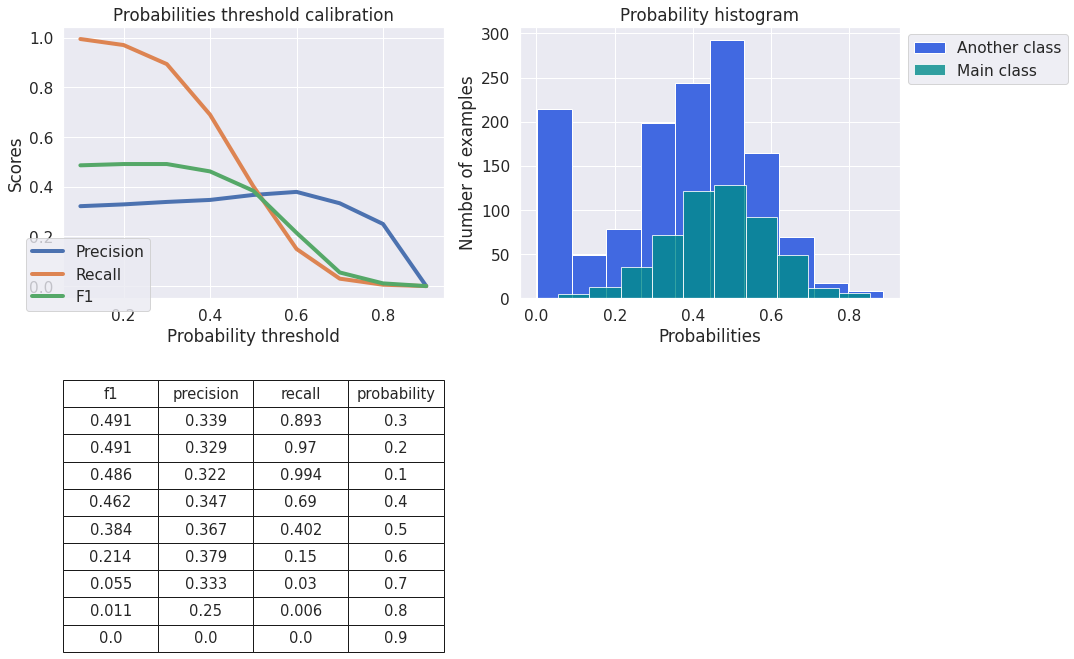

In [ ]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [ ]:
final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=7, learning_rate=0.1,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4047
           1       0.84      0.81      0.82      3156

    accuracy                           0.85      7203
   macro avg       0.85      0.84      0.85      7203
weighted avg       0.85      0.85      0.85      7203

TEST

              precision    recall  f1-score   support

           0       0.75      0.72      0.74      1340
           1       0.37      0.40      0.38       535

    accuracy                           0.63      1875
   macro avg       0.56      0.56      0.56      1875
weighted avg       0.64      0.63      0.64      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               969  371
1               320  215


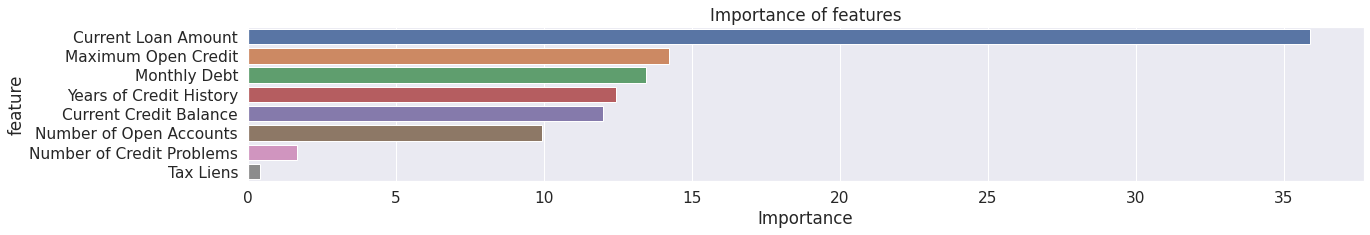

In [ ]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [ ]:
important_features_top

['Current Loan Amount',
 'Maximum Open Credit',
 'Monthly Debt',
 'Years of Credit History',
 'Current Credit Balance',
 'Number of Open Accounts',
 'Number of Credit Problems',
 'Tax Liens']

In [ ]:
final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=7, learning_rate=0.1,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4047
           1       0.83      0.81      0.82      3156

    accuracy                           0.85      7203
   macro avg       0.84      0.84      0.84      7203
weighted avg       0.85      0.85      0.85      7203

TEST

              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1340
           1       0.37      0.39      0.38       535

    accuracy                           0.64      1875
   macro avg       0.56      0.56      0.56      1875
weighted avg       0.64      0.64      0.64      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               981  359
1               325  210


In [ ]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)